# Time Analysis
* In this notebook, we use the logs we created for each translation to have a better look at the translation times

## Time per Task
* Each procedure ran a number of tasks and each time a task completed, it logged the time it took for the task to execute.
* This includes automatic retries that were triggered by GPT4.1 code; it reflects the actual time we had to wait for a task to finish

In [1]:
from os.path import join
import json
from collections import defaultdict
with open(join('translations', 'info.json'), 'r') as f:
    prefix2file = json.load(f)
    
procs = [f'proc{i}' for i in range(1, 7)]
proc2tasks = {}

for proc in procs:
    for prefix, info in prefix2file.items():
        if info.get('procedure', None) == proc:
            task_id = info['task']['task_id']
            duration = info['task']['duration']
            if proc == 'proc1':
                tl = info['task']['translator']
                if tl == 'deepl_document':
                    key = f'proc1-deepl'
                else:
                    key = f'proc1-gpt'
            else:
                key = proc
            if key not in proc2tasks:
                proc2tasks[key] = {}
            if task_id not in proc2tasks[key]:
                proc2tasks[key][task_id] = duration

In [2]:
for k, v in proc2tasks.items():
    num_tasks = len(v)
    total_minutes = sum(v.values()) / 60
    label = f'{k} ({num_tasks})'
    print(f"{label:<15} {total_minutes:>10.1f} min")

proc1-deepl (3)        8.8 min
proc1-gpt (3)        156.1 min
proc2 (1)            245.0 min
proc3 (5)            408.0 min
proc4 (10)           310.0 min
proc5 (2)             49.8 min
proc6 (2)             38.6 min


## Time per Translation
* Exluces automatic retries
* Aggregation of each individual translated item, where start and end timestamps where generated when API call was made and response was received

In [3]:
from os.path import join
import json
from collections import defaultdict
with open(join('translations', 'info.json'), 'r') as f:
    prefix2file = json.load(f)
    
procs = [f'proc{i}' for i in range(1, 7)]

total_time = defaultdict(int)

for proc in procs:
    for prefix, info in prefix2file.items():
        if info.get('procedure', None) == proc:
            duration = info['log']['end'] - info['log']['start']
            if proc == 'proc1':
                tl = info['task']['translator']
                if tl == 'deepl_document':
                    key = f'proc1-deepl'
                else:
                    key = f'proc1-gpt'
            else:
                key = proc
            total_time[key] += duration

In [4]:
for k, v in total_time.items():
    total_minutes = v / 60
    label = f'{k}'
    print(f"{label:<15} {total_minutes:>10.1f} min")

proc1-deepl            8.6 min
proc1-gpt            145.9 min
proc2                163.3 min
proc3                166.4 min
proc4                272.4 min
proc5                 17.1 min
proc6                 37.8 min


* We can see that the precise times for proc2 and 3 have a larger impact; it makes more sense to use the precise times to have an idea of how long it takes GPT4.1 to translate text.

In [5]:
print(f'DeepL: {(total_time['proc1-deepl']+total_time['proc6'])/60:.2f}min')
print(f'GPT4.1: {(total_time['proc1-gpt'
      ]+total_time['proc2']+total_time['proc3']+total_time['proc4'])/60:.2f}min')

DeepL: 46.48min
GPT4.1: 748.00min


* For the same workload, GPT took in total roughly 16 times as much as DeepL
    * Excluding the additional retries from Proc5
* However, if we exclude the automatic retries, GPT is 8.5 times cheaper. 

# Exploiting Existing Systems
* To take advantage of code that we already have for correlations and visualizations, we can pretend that certain attributes that we are interested in are equivalent to metrics such as BLEU score.

In [6]:
from os.path import join
import pandas as pd
import json

time2df = {}

parts = ['ep-gpt', 'ep-deepl', 'flores-gpt',
         'flores-deepl', 'opus-gpt', 'opus-deepl']

with open(join('translations', 'info.json'), 'r') as f:
    prefix2file = json.load(f)

for part in parts:
    data = {'Label': [], 'Time': [], 'Out_Tokens': [], 'In_Tokens': [], 'Chars': []}
    for prefix, info in prefix2file.items():
        if prefix.startswith(part):
            src_lang, tgt_lang = prefix.split('-')[2], prefix.split('-')[3]
            duration = info['log']['end'] - info['log']['start']
            data['Label'].append(f'{src_lang}-{tgt_lang}')
            data['Time'].append(duration)
            data['Chars'].append(info['log']['in_chars'])
            if part.endswith('gpt'):
                data['Out_Tokens'].append(info['log']['out_model_tokens'])
                data['In_Tokens'].append(info['log']['in_model_tokens'])
            if part.endswith('deepl'):
                data['In_Tokens'].append(info['log']['out_tokens'])
                data['Out_Tokens'].append(info['log']['in_tokens'])

    df = pd.DataFrame(data)
    time2df[part] = df

In [7]:
for k in time2df:
    print(k, len(time2df[k]))

ep-gpt 110
ep-deepl 110
flores-gpt 110
flores-deepl 110
opus-gpt 20
opus-deepl 20


In [8]:
import os
import pandas as pd
from os.path import join
files = os.listdir('comet_results')
res2df = {}
for fi in files:
    df = pd.read_csv(join('comet_results', fi))
    res2df[fi.replace('.csv', '')] = df

In [9]:
for k in res2df:
    print(k, len(res2df[k]))

ep-deepl 110
ep-gpt 110
flores-deepl 110
flores-gpt 110
opus-deepl 20
opus-gpt 20


In [10]:
new = {}
for k in res2df:
    df1 = res2df[k]
    df2 = time2df[k]
    df3 = pd.merge(df1, df2, on='Label')
    new[k] = df3

In [11]:
os.makedirs('enriched_results', exist_ok=True)
for k in new:
    df = new[k]
    df.to_csv(join('enriched_results', f'{k}.csv'))

## Time Analysis GPT

In [12]:
from scripts.presentation import Presenter
results_folder = 'enriched_results'
p = Presenter(results_folder=results_folder, metrics=['BLEU', 'chrF', 'Time', 'Out_Tokens', 'In_Tokens', 'Chars', 'COMET'])

Datasets: ['ep', 'flores', 'opus'] : ['ep', 'flores', 'opus']
Translators: ['gpt'] : ['gpt']
Metric: BLEU : Time
Pearson correlation: -0.43 (p = 3.6e-12)
Spearman correlation: -0.44 (p = 1.2e-12)



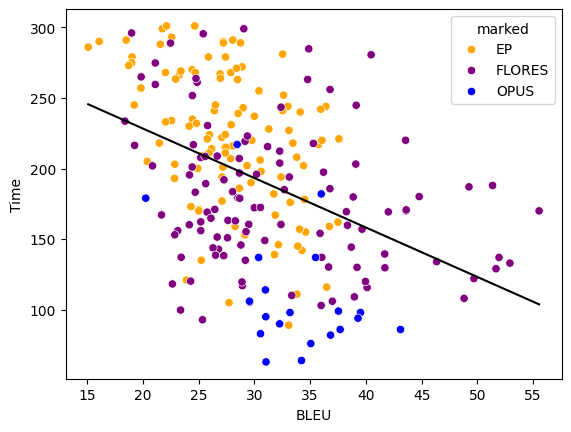

In [13]:
datasets = ['ep', 'flores', 'opus']
config1 = {
    'datasets': datasets,
    'translators': ['gpt'],
    'src_lang': None,
    'tgt_lang': None,
    'metric': 'BLEU'
}
config2 = {
    'datasets': datasets,
    'translators': ['gpt'],
    'src_lang': None,
    'tgt_lang': None,
    'metric': 'Time'
}
p.show_correlations(config1, config2)
data, model = p.linear_regression(config1, config2, 'BLEU', 'Time', custom_color={'dataset': {'ep': 'orange', 'flores': 'purple', 'opus': 'blue'}})

Datasets: ['ep', 'flores', 'opus'] : ['ep', 'flores', 'opus']
Translators: ['gpt'] : ['gpt']
Metric: Out_Tokens : Time
Pearson correlation: 0.68 (p = 3.0e-34)
Spearman correlation: 0.69 (p = 2.1e-35)



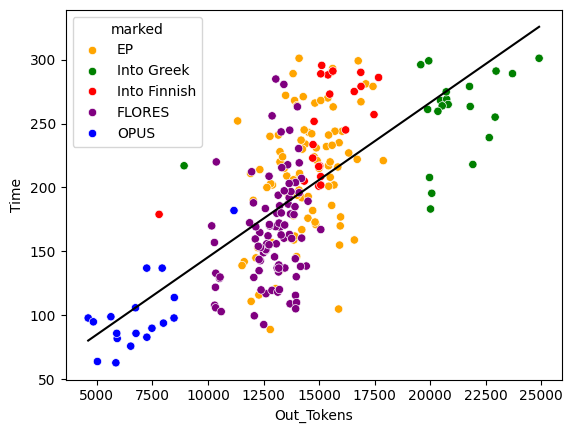

In [14]:
datasets = ['ep', 'flores', 'opus']
config1 = {
    'datasets': datasets,
    'translators': ['gpt'],
    'src_lang': None,
    'tgt_lang': None,
    'metric': 'Out_Tokens'
}
config2 = {
    'datasets': datasets,
    'translators': ['gpt'],
    'src_lang': None,
    'tgt_lang': None,
    'metric': 'Time'
}
p.show_correlations(config1, config2)
data, model = p.linear_regression(config1, config2, 'Out_Tokens', 'Time', custom_color={'tgt_lang': {'fi': 'red', 'el': 'green'}, 'dataset':{'opus':'blue', 'ep':'orange', 'flores':'purple'}})



In [15]:
df = data
df = df[df['tgt_lang'] == 'fi']
df.sort_values(by='score_x').head(1)

,src_lang,tgt_lang,score_x,dataset,translator_x,score_y,translator_y,marked
239,en,fi,7799.0,opus,gpt,179.0,gpt,Into Finnish


* The outlier we observe for Finnish is the one from OPUS100, which makes sense, as OPUS has substantially smaller sentences than EuroParl and FLORES+

In [16]:
df = data
df_opus = df[df['dataset'] == 'opus']
df_ep = df[df['dataset'] == 'ep']
df_flores = df[df['dataset'] == 'flores']
print(f'EP Avg. Tokens: {df_ep["score_x"].mean():.2f}')
print(f'Opus Avg. Tokens: {df_opus["score_x"].mean():.2f}')
print(f'Flores Avg. Tokens: {df_flores["score_x"].mean():.2f}')

EP Avg. Tokens: 15283.40
Opus Avg. Tokens: 7026.00
Flores Avg. Tokens: 13747.45


* The reason why GPT4.1 had such a hard time with Greek translation was likely because it required more tokens to produce them.
* It is noteworthy, that DeepL required more tokens as well but it did not affect the translation time. It is also worth mentioning that DeepL is actually not even using tokens but characters.
* As for Finnish, the reason is less clear. The token count cannot be the sole reason, as we can see in the visualization that Finnish is not too different from the other Europarl/Flores translations in terms of tokens. 

In [17]:
src2time = {}
for src_lang in df['src_lang'].unique():
    src2time[src_lang] = df[df['src_lang'] == src_lang]['score_y'].mean()
    
tgt2time = {}
for tgt_lang in df['tgt_lang'].unique():
    tgt2time[tgt_lang] = df[df['tgt_lang'] == tgt_lang]['score_y'].mean()

for k, v in sorted(src2time.items(), key=lambda x: x[1], reverse=True):
    print(f'{k}: {v:.2f}')

el: 213.58
fr: 207.07
fi: 205.46
nl: 202.72
pt: 201.80
it: 196.48
de: 186.67
es: 186.26
da: 184.25
sv: 180.11
en: 165.13


In [18]:
for k, v in sorted(tgt2time.items(), key=lambda x: x[1], reverse=True):
    print(f'{k}: {v:.2f}')

el: 256.90
fi: 247.87
de: 208.05
da: 205.14
fr: 194.92
sv: 192.91
nl: 192.83
it: 187.44
pt: 170.90
es: 162.32
en: 126.73


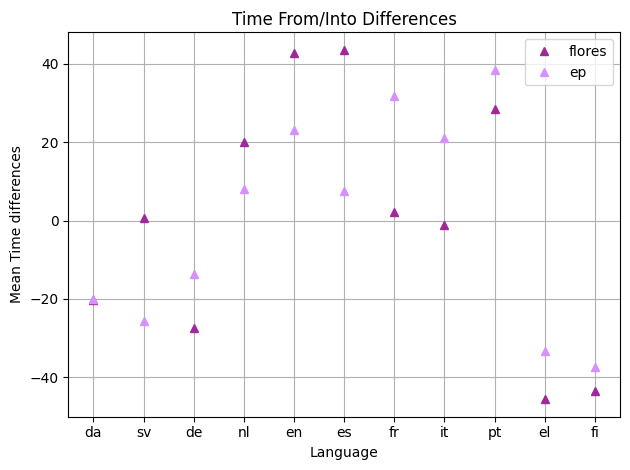

In [19]:
_ = p.mean_metric_from_or_into_lang(
    mode='DIFF', metric='Time', merge='DATASET', with_koehn=False, focus=['ep-gpt', 'flores-gpt'])

* Positive means: It took more time to translate From the language 
* Negative means it took more time to translate Into the language. 
* We can observe that both Greek and Finnish took longer to translate INTO than translate FROM. 
* Thus, we can assume that the reason why timetout errors occured specifically for INTO Greek and Finnish translation may be related to the same reason why it takes GPT4.1 longer to translate into them.
    * For Greek, this may be related to the higher number of output tokens required
    * For Finnish, this may be related to the linguistic complexity of the language itself; so it is just a hard language to translate into in general; indicated by lower BLEU scores not only in Koehn's results in 2005 but also ours
    * However, analysing Finnish with different metrics, makes it seem like it is not difficult to translate into Finnish; so either the metrics are not consistent or there is a different reason why Finnish specifically was difficult for GPT4.1

### Approximating GPT Cost
* We can compute the GPT costs using the structured logs of the translations we use, but we might as well try to compute or at least approximate how much money in total was spent on everything; as each automatic retry in procedure 2 and 3 generated a response and deducted from our credits

Datasets: ['ep', 'flores', 'opus'] : ['ep', 'flores', 'opus']
Translators: ['gpt'] : ['gpt']
Metric: In_Tokens : Out_Tokens
Pearson correlation: 0.43 (p = 4.5e-12)
Spearman correlation: 0.37 (p = 2.5e-09)



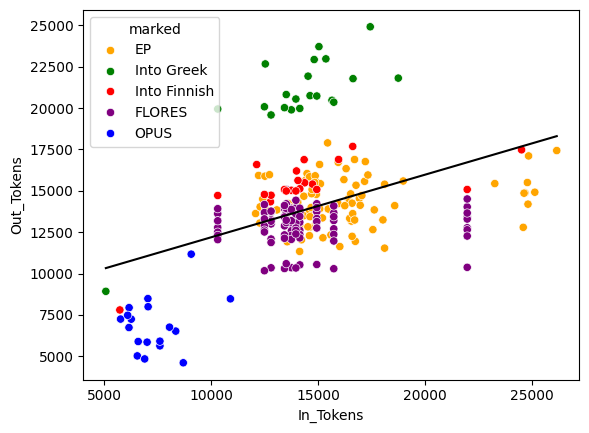

In [20]:
datasets = ['ep', 'flores', 'opus']
translators = ['gpt', 'deepl']
tl2data = {t: {} for t in translators}

config1 = {
    'datasets': datasets,
    'translators': ['gpt'],
    'src_lang': None,
    'tgt_lang': None,
    'metric': 'In_Tokens'
}
config2 = {
    'datasets': datasets,
    'translators': ['gpt'],
    'src_lang': None,
    'tgt_lang': None,
    'metric': 'Out_Tokens'
}
p.show_correlations(config1, config2)
data, model = p.linear_regression(config1, config2, 'In_Tokens', 'Out_Tokens', custom_color={'tgt_lang': {
                                  'fi': 'red', 'el': 'green'}, 'dataset': {'opus': 'blue', 'ep': 'orange', 'flores': 'purple'}})

In [21]:
df = data
GPT41_RATE = (2.00 * 1e-6, 8.0 * 1e-6)
max_cost = df['score_x'].max() * GPT41_RATE[0] + df['score_y'].max() * GPT41_RATE[1]
min_cost = df['score_x'].min() * GPT41_RATE[0] + df['score_y'].min() * GPT41_RATE[1]
mean_cost = df['score_x'].mean() * GPT41_RATE[0] + df['score_y'].mean() * GPT41_RATE[1]
print(f'Max: {max_cost:.2f}, Min: {min_cost:.2f}')
print(f'Mean: {mean_cost:.2f}')


Max: 0.25, Min: 0.05
Mean: 0.14


In [22]:
total_cost_translated = df['score_x'].sum() * GPT41_RATE[0] + df['score_y'].sum() * GPT41_RATE[1]
print(f'Total cost for translated documents: ${total_cost_translated:.2f}')

Total cost for translated documents: $33.63


* Now we want to compute the additional cost for each retry; we make an over-estimation by multiplying the total number of automatic retries by the max cost of a single translation

In [23]:
!cat proc1.log proc2.log proc3.log | grep -P "^INFO" | grep -P "Retrying request to /chat/completions" | wc -l

50


In [24]:
additional_cost = 50 * max_cost
print(f'Total cost for translated documents, including retries: ${total_cost_translated + additional_cost:.2f}')

Total cost for translated documents, including retries: $46.21


* For DeepL, it is easy to confirm this cost, for GPT4.1 not as much as we did additional experiments on the side, 'off-screen', so viewing the usage on OpenAI's platform would not be accurate.

## Time Analysis DeepL

Datasets: ['ep', 'flores', 'opus'] : ['ep', 'flores', 'opus']
Translators: ['deepl'] : ['deepl']
Metric: Out_Tokens : Time
Pearson correlation: 0.39 (p = 6.5e-10)
Spearman correlation: 0.48 (p = 1.7e-15)



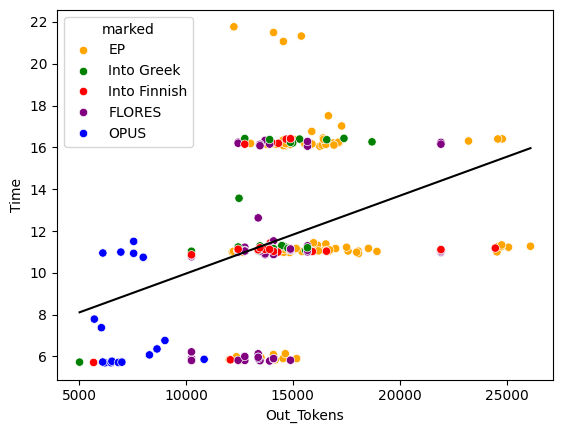

In [25]:
datasets = ['ep', 'flores', 'opus']
translators = ['gpt', 'deepl']
tl2data = {t: {} for t in translators}

config1 = {
    'datasets': datasets,
    'translators': ['deepl'],
    'src_lang': None,
    'tgt_lang': None,
    'metric': 'Out_Tokens'
}
config2 = {
    'datasets': datasets,
    'translators': ['deepl'],
    'src_lang': None,
    'tgt_lang': None,
    'metric': 'Time'
}
p.show_correlations(config1, config2)
data, model = p.linear_regression(config1, config2, 'Out_Tokens', 'Time', custom_color={'tgt_lang': {'fi': 'red', 'el': 'green'}, 'dataset':{'opus':'blue', 'ep':'orange', 'flores':'purple'}})



* Correlation analysis for DeepL does not seem too smart, the regular distances between each other more a sign of fixed 5 seconds delays they had in their 
* Recall: DeepL makes an API call and then regularly checks if it is done and then retrieves it. GPT4.1 initially worked similary but there was no check with fixed delay; we just wait for a response and sometimes the response did not come at all. Then we switched to streaming, where the response was streamed directly to us. 

In [26]:
!cat proc1.log | grep -P -A10 'DeepL API response' | head -n 8 | tail -n 1

INFO: 2025-05-07 14:57:37 - Rechecking document translation status after sleeping for 5.000 seconds. 


In [27]:
df = data
df.sort_values(by='score_y', ascending=False)[['src_lang', 'tgt_lang', 'score_y']].head(5)

,src_lang,tgt_lang,score_y
33,en,nl,21.768036
52,de,es,21.494549
77,pt,it,21.324425
47,pt,en,21.065953
81,sv,pt,17.511968


In [28]:
buckets = {k: [] for k in [6, 11, 16, 22]}

for _, row in df.iterrows():
    dist = {k: abs(row['score_y'] - k) for k in buckets}
    min_key = min(dist, key=dist.get)
    buckets[min_key].append(row)

buckets = {k: pd.DataFrame(rows) for k, rows in buckets.items()}

In [29]:
for k, v in buckets.items():
    avg_score = v['score_y'].mean()
    print(f'{k}: {avg_score:.2f}')

6: 5.99
11: 11.11
16: 16.23
22: 21.41


In [30]:
for k, v in buckets.items():
    print(k)
    print(v['src_lang'].value_counts().head(3))
    print(v['tgt_lang'].value_counts().head(3))
    print('')

6
src_lang
en    17
de     9
nl     4
Name: count, dtype: int64
tgt_lang
en    16
es     6
fr     5
Name: count, dtype: int64

11
src_lang
fi    16
es    15
sv    15
Name: count, dtype: int64
tgt_lang
de    16
pt    15
fi    14
Name: count, dtype: int64

16
src_lang
pt    10
it     9
fr     7
Name: count, dtype: int64
tgt_lang
da    13
sv     9
el     9
Name: count, dtype: int64

22
src_lang
pt    2
en    1
de    1
Name: count, dtype: int64
tgt_lang
nl    1
en    1
es    1
Name: count, dtype: int64



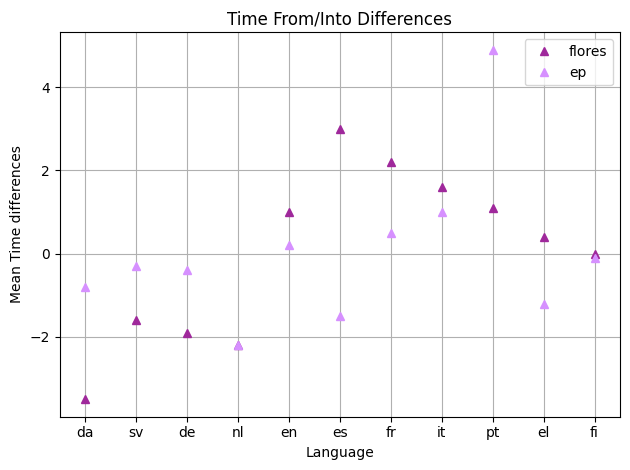

In [31]:
_ = p.mean_metric_from_or_into_lang(
    mode='DIFF', metric='Time', merge='DATASET', with_koehn=False, focus=['ep-deepl', 'flores-deepl'])

### Computing DeepL Cost
* Less of an approximation, as it is much more straightforward and can be even confirmed directly on our DeepL Account

Datasets: ['ep', 'flores', 'opus'] : ['ep', 'flores', 'opus']
Translators: ['deepl'] : ['deepl']
Metric: Chars : Time
Pearson correlation: 0.45 (p = 4.4e-13)
Spearman correlation: 0.45 (p = 1.3e-13)



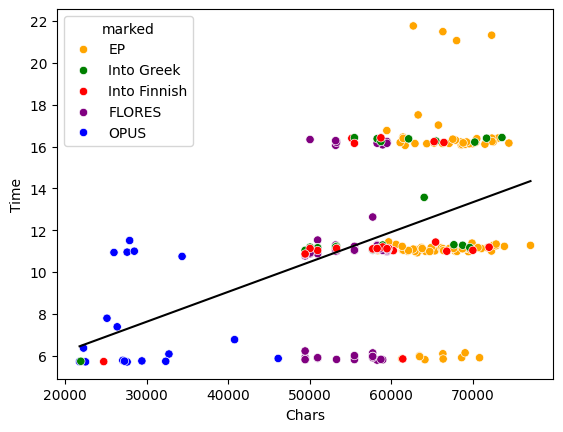

In [32]:
config1 = {
    'datasets': datasets,
    'translators': ['deepl'],
    'src_lang': None,
    'tgt_lang': None,
    'metric': 'Chars'
}
config2 = {
    'datasets': datasets,
    'translators': ['deepl'],
    'src_lang': None,
    'tgt_lang': None,
    'metric': 'Time'
}
p.show_correlations(config1, config2)
data, model = p.linear_regression(config1, config2, 'Chars', 'Time', custom_color={'tgt_lang': {
                                  'fi': 'red', 'el': 'green'}, 'dataset': {'opus': 'blue', 'ep': 'orange', 'flores': 'purple'}})

In [33]:
df = data
DEEPL_RATE = 2e-5
df['score_x'].sum() * DEEPL_RATE
print(f'Total cost for DeepL translations: €{df["score_x"].sum() * DEEPL_RATE:.2f}')

Total cost for DeepL translations: €278.36


* This is correct, on our account, we usage cost of: `€278.39`

In [34]:
!rm -rf enriched_results/